In [ ]:
%%capture
!pip install qiskit
!pip install qiskit_aer_gpu
!pip install qiskit_ionq_provider-0.0.1.dev0+45bd6b1-py3-none-any.whl

In [ ]:
#initialization
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch, Rectangle
import numpy as np
import copy

# importing Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
# from qiskit_ionq_provider import IonQProvider

# import basic plot tools
from qiskit.visualization import plot_histogram

# Grover Search Quantum Gate Methods

In [ ]:
def x_rotation(qc, move, control, target):
  qc.x(move)
  qc.toffoli(move, control, target)
  qc.x(move)

def y_rotation(qc, move, control, target):
  qc.toffoli(move, control, target)

def oracle(qc, m_qubits, c_qubits, output_qubit):
  for i in range(len(m_qubits)):
    x_rotation(qc, i, c_qubits[0], c_qubits[1])
    qc.barrier()
    y_rotation(qc, i, c_qubits[1], c_qubits[0])
    qc.barrier()

  qc.toffoli(c_qubits[0], c_qubits[1], output_qubit)
  qc.barrier()

  for i in range(len(m_qubits)-1,-1,-1):
    y_rotation(qc, i, c_qubits[1], c_qubits[0])
    qc.barrier()
    x_rotation(qc, i, c_qubits[0], c_qubits[1])
    qc.barrier()



In [ ]:
# def diffuser(qc, m_qubits, c_qubits, output_qubit):
#   qc.h(m_qubits)
#   qc.z(m_qubits)
#   qc.cz(m_qubits[0], m_qubits[1])
#   qc.h(m_qubits)

# def diffuser(qc, m_qubits, c_qubits, output_qubit):
#   # Apply transformation |s> -> |00..0> (H-gates)
#   for qubit in m_qubits:
#       qc.h(qubit)
#   # Apply transformation |00..0> -> |11..1> (X-gates)
#   for qubit in m_qubits:
#       qc.x(qubit)
#   # Do multi-controlled-Z gate
#   qc.h(m_qubits[-1])
#   qc.mct(m_qubits[:-1], m_qubits[-1])  # multi-controlled-toffoli
#   qc.h(m_qubits)
#   # Apply transformation |11..1> -> |00..0>
#   for qubit in m_qubits:
#       qc.x(qubit)
#   # Apply transformation |00..0> -> |s>
#   for qubit in m_qubits:
#       qc.h(qubit)
#   qc.barrier()

def diffuser(nqubits):
    q = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        q.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        q.x(qubit)
    # Do multi-controlled-Z gate
    q.h(nqubits-1)
    q.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    q.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        q.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        q.h(qubit)
    # We will return the diffuser as a gate
    U_s = q.to_gate()
    U_s.name = "U$_s$"
    return U_s
  

In [ ]:
def gen_cube_state(qc, c_qubits, cube_array): 
  # cube array is 2d array
  # |a b| 
  # |c d| becomes [[a,b],[c,d]]
  c0 = (cube_array[1][0] == cube_array[1][1]) # c == d
  c1 = (cube_array[0][1] == cube_array[1][1]) # b == d

  if c0:
    qc.x(c_qubits[0])
  if c1:
    qc.x(c_qubits[1])



In [ ]:
def grover_iteration(qc, m_qubits, c_qubits, output_qubit):
  oracle(qc, m_qubits, c_qubits, output_qubit)
  qc.append(diffuser(len(m_qubits)), m_qubits)
  # diffuser(qc, m_qubits, c_qubits, output_qubit)
  qc.barrier()

# Grover Search Rubik's Cube Simulation

In [ ]:
num_moves = 4
init_state = [[0,0],[1,1]]


# Initialize registers and quantum circuit
m_qubits = QuantumRegister(num_moves, name = 'm')
c_qubits = QuantumRegister(2, name = 'c')
output_qubit = QuantumRegister(1, name = 'out')
classical_bits = ClassicalRegister(num_moves, name = 'cbits')
qc = QuantumCircuit(m_qubits, c_qubits, output_qubit, classical_bits)

# Initialize move sequence (m_qubits) to superposition
qc.h(m_qubits)

# Initialize cube state (c_qubits) 
gen_cube_state(qc, c_qubits, init_state)

# Initialize output qubit to state |->
qc.x(output_qubit)
qc.h(output_qubit)
qc.barrier()

# Grover iteration
num_iterations = 1
for i in range(num_iterations):
  grover_iteration(qc, m_qubits, c_qubits, output_qubit)


# Measure the move sequence qubits (m_qubits)
qc.measure(m_qubits, classical_bits)

qc.draw()

┌───┐      ░ ┌───┐     ┌───┐ ░       ░                 ░       ░      »
    m_0: ┤ H ├──────░─┤ X ├──■──┤ X ├─░───■───░─────────────────░───────░──────»
         ├───┤      ░ └───┘  │  └───┘ ░   │   ░ ┌───┐     ┌───┐ ░       ░      »
    m_1: ┤ H ├──────░────────┼────────░───┼───░─┤ X ├──■──┤ X ├─░───■───░──────»
         ├───┤      ░        │        ░   │   ░ └───┘  │  └───┘ ░   │   ░ ┌───┐»
    m_2: ┤ H ├──────░────────┼────────░───┼───░────────┼────────░───┼───░─┤ X ├»
         ├───┤      ░        │        ░   │   ░        │        ░   │   ░ └───┘»
    m_3: ┤ H ├──────░────────┼────────░───┼───░────────┼────────░───┼───░──────»
         ├───┤      ░        │        ░ ┌─┴─┐ ░        │        ░ ┌─┴─┐ ░      »
    c_0: ┤ X ├──────░────────■────────░─┤ X ├─░────────■────────░─┤ X ├─░──────»
         └───┘      ░      ┌─┴─┐      ░ └─┬─┘ ░      ┌─┴─┐      ░ └─┬─┘ ░      »
    c_1: ───────────░──────┤ X ├──────░───■───░──────┤ X ├──────░───■───░──────»
         ┌───┐┌───┐ ░      └───┘      ░       ░      └───┘      ░       ░      »
  out_0: ┤ X ├┤ H ├─░─────────────────░───────░─────────────────░───────░──────»
         └───┘└───┘ ░                 ░       ░                 ░       ░      »
cbits: 4/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                    ░       ░                 ░       ░       ░       ░      »
«    m_0: ───────────░───────░─────────────────░───────░───────░───────░──────»
«                    ░       ░                 ░       ░       ░       ░      »
«    m_1: ───────────░───────░─────────────────░───────░───────░───────░──────»
«              ┌───┐ ░       ░                 ░       ░       ░       ░      »
«    m_2: ──■──┤ X ├─░───■───░─────────────────░───────░───────░───────░──────»
«           │  └───┘ ░   │   ░ ┌───┐     ┌───┐ ░       ░       ░       ░ ┌───┐»
«    m_3: ──┼────────░───┼───░─┤ X ├──■──┤ X ├─░───■───░───────░───■───░─┤ X ├»
«           │        ░ ┌─┴─┐ ░ └───┘  │  └───┘ ░ ┌─┴─┐ ░       ░ ┌─┴─┐ ░ └───┘»
«    c_0: ──■────────░─┤ X ├─░────────■────────░─┤ X ├─░───■───░─┤ X ├─░──────»
«         ┌─┴─┐      ░ └─┬─┘ ░      ┌─┴─┐      ░ └─┬─┘ ░   │   ░ └─┬─┘ ░      »
«    c_1: ┤ X ├──────░───■───░──────┤ X ├──────░───■───░───■───░───■───░──────»
«         └───┘      ░       ░      └───┘      ░       ░ ┌─┴─┐ ░       ░      »
«  out_0: ───────────░───────░─────────────────░───────░─┤ X ├─░───────░──────»
«                    ░       ░                 ░       ░ └───┘ ░       ░      »
«cbits: 4/════════════════════════════════════════════════════════════════════»
«                                                                             »
«                    ░       ░                 ░       ░                 ░ »
«    m_0: ───────────░───────░─────────────────░───────░─────────────────░─»
«                    ░       ░                 ░       ░ ┌───┐     ┌───┐ ░ »
«    m_1: ───────────░───────░─────────────────░───■───░─┤ X ├──■──┤ X ├─░─»
«                    ░       ░ ┌───┐     ┌───┐ ░   │   ░ └───┘  │  └───┘ ░ »
«    m_2: ───────────░───■───░─┤ X ├──■──┤ X ├─░───┼───░────────┼────────░─»
«              ┌───┐ ░   │   ░ └───┘  │  └───┘ ░   │   ░        │        ░ »
«    m_3: ──■──┤ X ├─░───┼───░────────┼────────░───┼───░────────┼────────░─»
«           │  └───┘ ░ ┌─┴─┐ ░        │        ░ ┌─┴─┐ ░        │        ░ »
«    c_0: ──■────────░─┤ X ├─░────────■────────░─┤ X ├─░────────■────────░─»
«         ┌─┴─┐      ░ └─┬─┘ ░      ┌─┴─┐      ░ └─┬─┘ ░      ┌─┴─┐      ░ »
«    c_1: ┤ X ├──────░───■───░──────┤ X ├──────░───■───░──────┤ X ├──────░─»
«         └───┘      ░       ░      └───┘      ░       ░      └───┘      ░ »
«  out_0: ───────────░───────░─────────────────░───────░─────────────────░─»
«                    ░       ░                 ░       ░                 ░ »
«cbits: 4/═════════════════════════════════════════════════════════════════»
«                                       

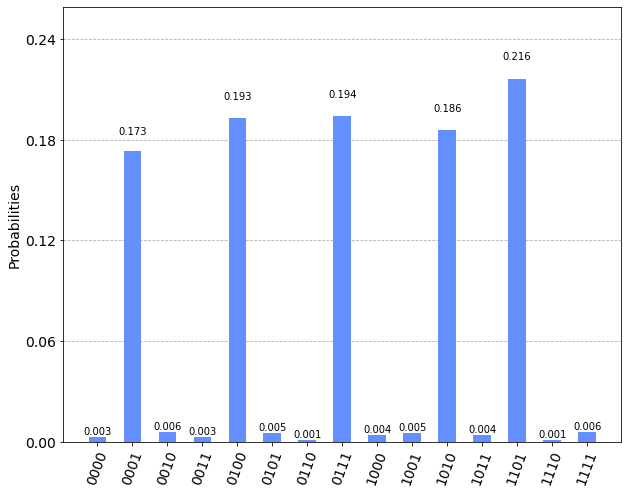

In [ ]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = qasm_simulator, shots = 1000).result()
plot_histogram(result.get_counts(),figsize = (10,8))

# Calculate Success Probability

In [ ]:
block_size= (64, 64)
W = np.pad(np.ones(block_size), 1)
B = np.pad(np.zeros(block_size)+0.69, 1)

In [ ]:
def flip(color):
  return B if (color == W).all() else W
  
def next_rubix_cube_state(state, move):
  new_state = copy.deepcopy(state)
  #state = [[W,B], [W,B]]
  if int(move) == 0: #rotate x
    new_state[1][0] = flip(state[1][1])
    new_state[1][1] = flip(state[1][0])

  elif int(move) == 1: #rotate y
    new_state[0][1] = flip(state[1][1])

    new_state[1][1] = flip(state[0][1])
  return new_state


def check_valid_state(state, moves):
  for i, m in enumerate(moves, start=1):
    state = next_rubix_cube_state(state, m)

  return all([(state[0][0] == state[0][1]).all(), 
              (state[0][1] == state[1][1]).all(), 
              (state[1][1] == state[1][0]).all()])



In [ ]:
def calc_prob_success(results_dic, init_state):
  correct = 0
  total = 0
  for move_sequence, count in results_dic.items():
    state = copy.deepcopy(init_state)
    if check_valid_state(state, reversed(move_sequence)):
      correct += count
    total += count
  print('Correct Probability: ', correct/total)
  


In [ ]:
start_state = [[W if x == 1 else B for x in row] for row in init_state]
calc_prob_success(result.get_counts(), start_state)

Correct Probability:  0.962


# Visualization

In [ ]:
def plot_state(state, ax, caption=None):
  ax.imshow(np.block(state), cmap='gray',  vmin=0,vmax=1)
  
  if caption:
    ax.set_title(caption)
  ax.axis('off')


In [ ]:
def plot_rectangle(ax, move, len_of_moves):
  if move == 0:
    rect = Rectangle((0, block_size[0]+1), block_size[1]*2+3, block_size[0]+1, linewidth=5, linestyle='--', edgecolor='c',facecolor='none') 

  else:
    rect = Rectangle((block_size[0]+1,0), block_size[0]+1, block_size[1]*2+3,linewidth=5, linestyle='--', edgecolor='c',facecolor='none') 

  ax.add_patch(rect)
  hard_code_val = {2: 32, 3: 17, 4: 18, 5: 16, 6:15}
  ax.text(
    2*block_size[0]+ hard_code_val[len_of_moves], block_size[0]+1, " "*10, ha="center", va="center", size=10-len_of_moves,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="black", ec="black", lw=2))

In [ ]:
def print_rubix_cube_moves(state, seq_of_moves):
  
  fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=len(seq_of_moves) + 1)
  plot_state(state, ax.flatten()[0], 'Inital State')
  for i, m in enumerate(seq_of_moves, start=1):
    ax_i = ax.flatten()[i]
    prev_ax = ax.flatten()[i-1]
    plot_rectangle(prev_ax, m, len(seq_of_moves))
    
    state = next_rubix_cube_state(state, m)
    plot_state(state, ax_i, f'State {i}' if i != len(seq_of_moves) else f'Solved State')

  

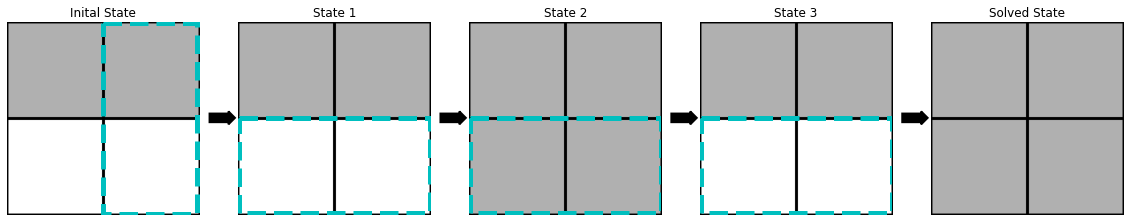

In [ ]:
start_state = [[W if x == 1 else B for x in row] for row in init_state]
moves = [1,0,0,0]
print_rubix_cube_moves(start_state, moves)